In [ ]:
!pip install optuna
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.1 MB/s eta 0:00:00


Trial 60 Complete [00h 00m 17s]
val_loss: 0.00027685824898071587

Best val_loss So Far: 5.499200415215455e-05
Total elapsed time: 00h 17m 13s

بهترین هایپرپارامترها:
n_layers: 1
filters_1: 160
kernel_size_1: 2
dropout_1: 0.1
dense_units: 48
learning_rate: 0.001
filters_2: 192
kernel_size_2: 2
dropout_2: 0.4
filters_3: 192
kernel_size_3: 2
dropout_3: 0.1
Epoch 1/50
115/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - root_mean_squared_error: 0.0597
Epoch 1: val_loss improved from inf to 0.00362, saving model to model_cnn/best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0042 - root_mean_squared_error: 0.0578 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 2/50
112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4101e-04 - root_mean_squared_error: 0.0209
Epoch 2: val_loss improved from 0.00362 to 0.00037, saving model to model_cnn/best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3669e-04 - root_mean_squared_error: 0.0208 - val_loss:

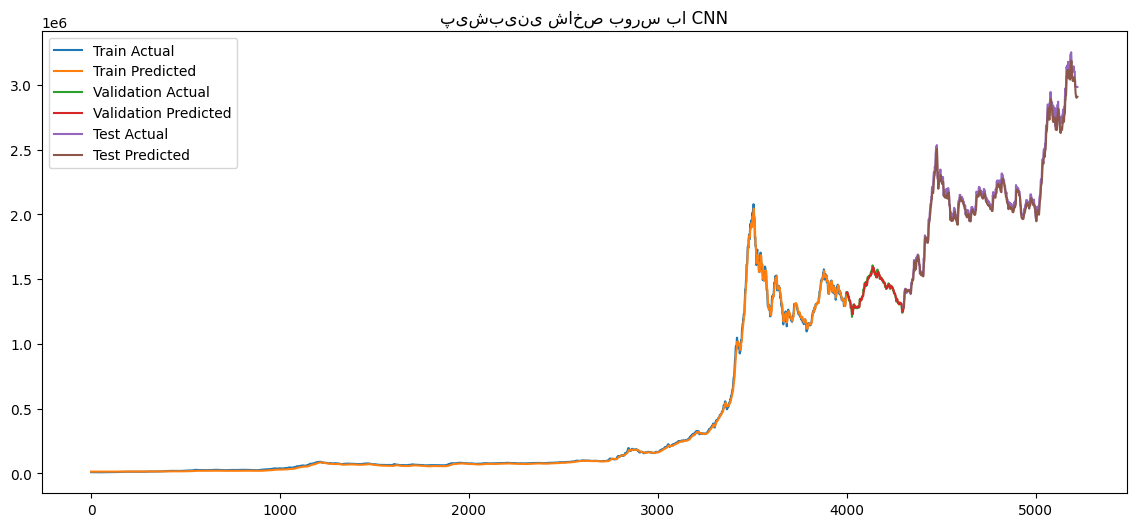

In [ ]:
# --------------------------
# کتابخانه‌ها
# --------------------------
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, InputLayer, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import random
import keras_tuner as kt

# --------------------------
# تنظیم seed
# --------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(seed)

# --------------------------
# خواندن دیتا
# --------------------------
df = pd.read_excel('DATASET.xlsx')
shakhes = df['SHAKHES']
df.index = pd.to_datetime(df['date_m'], format='%Y.%m.%d')

# --------------------------
# ساخت X و y با sliding window
# --------------------------
WINDOW_SIZE = 20
def df_to_X_y(series, window_size=20):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# --------------------------
# تقسیم X و y به train/val/test
# --------------------------
train_size = 4000
val_size = 300

shakhes_values = shakhes.values.reshape(-1,1)
X_all, y_all = df_to_X_y(shakhes_values, WINDOW_SIZE)
X_all = X_all.reshape(-1, WINDOW_SIZE, 1)
y_all = y_all.reshape(-1,1)

X_train, y_train = X_all[:train_size], y_all[:train_size]
X_val, y_val     = X_all[train_size:train_size+val_size], y_all[train_size:train_size+val_size]
X_test, y_test   = X_all[train_size+val_size:], y_all[train_size+val_size:]

# --------------------------
# نرمال‌سازی فقط روی داده train
# --------------------------
scaler = MinMaxScaler()
X_train_flat = X_train.reshape(-1, 1)
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)

def scale_X(X):
    X_flat = X.reshape(-1,1)
    X_scaled_flat = scaler.transform(X_flat)
    return X_scaled_flat.reshape(X.shape)

X_val_scaled = scale_X(X_val)
X_test_scaled = scale_X(X_test)

y_train_scaled = scaler.transform(y_train)
y_val_scaled   = scaler.transform(y_val)
y_test_scaled  = scaler.transform(y_test)

# --------------------------
# تابع مدل برای Keras Tuner با CNN
# --------------------------
def build_model_cnn(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train_scaled.shape[1], 1)))

    n_layers = hp.Int('n_layers', 1, 3)
    for i in range(n_layers):
        filters = hp.Int(f'filters_{i+1}', min_value=32, max_value=256, step=32)
        kernel_size = hp.Int(f'kernel_size_{i+1}', min_value=2, max_value=5)
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
        dropout = hp.Float(f'dropout_{i+1}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(Dropout(dropout))
        if i < n_layers - 1:
            model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))

    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=MeanSquaredError(),
        metrics=[RootMeanSquaredError()]
    )
    return model

# --------------------------
# Keras Tuner
# --------------------------
tuner = kt.RandomSearch(
    build_model_cnn,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cnn_stock_full'
)

tuner.search(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=20,
    batch_size=32,
    verbose=1
)

# بهترین هایپرپارامترها
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nبهترین هایپرپارامترها:")
for key in best_hp.values.keys():
    print(f"{key}: {best_hp.get(key)}")

# --------------------------
# ساخت مدل CNN با بهترین هایپرپارامترها
# --------------------------
model = tuner.hypermodel.build(best_hp)

# --------------------------
# Callbacks
# --------------------------
os.makedirs('model_cnn', exist_ok=True)
cp = ModelCheckpoint('model_cnn/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --------------------------
# آموزش مدل CNN
# --------------------------
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    batch_size=32,
    callbacks=[cp, es]
)

# --------------------------
# پیش‌بینی و بازگرداندن مقیاس
# --------------------------
model = tf.keras.models.load_model('model_cnn/best_model.keras')

def predict_and_rescale(X, y_true):
    y_pred = model.predict(X)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_true_rescaled = scaler.inverse_transform(y_true)
    return y_pred_rescaled, y_true_rescaled

train_pred, train_true = predict_and_rescale(X_train_scaled, y_train_scaled)
val_pred, val_true     = predict_and_rescale(X_val_scaled, y_val_scaled)
test_pred, test_true   = predict_and_rescale(X_test_scaled, y_test_scaled)

# --------------------------
# محاسبه معیارها
# --------------------------
def calc_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

train_metrics = calc_metrics(train_true, train_pred)
val_metrics   = calc_metrics(val_true, val_pred)
test_metrics  = calc_metrics(test_true, test_pred)

print("\nTrain - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}".format(*train_metrics))
print("Validation - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}".format(*val_metrics))
print("Test - MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}, R2: {:.4f}".format(*test_metrics))

# --------------------------
# نمودار پیش‌بینی
# --------------------------
plt.figure(figsize=(14,6))
plt.plot(train_true, label='Train Actual')
plt.plot(train_pred, label='Train Predicted')
plt.plot(range(len(train_true), len(train_true)+len(val_true)), val_true, label='Validation Actual')
plt.plot(range(len(train_true), len(train_true)+len(val_true)), val_pred, label='Validation Predicted')
plt.plot(range(len(train_true)+len(val_true), len(train_true)+len(val_true)+len(test_true)), test_true, label='Test Actual')
plt.plot(range(len(train_true)+len(val_true), len(train_true)+len(val_true)+len(test_true)), test_pred, label='Test Predicted')
plt.title('پیش‌بینی شاخص بورس با CNN')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# --------------------------
# TimeSeriesSplit
# --------------------------
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

mse_list, rmse_list, mae_list, r2_list = [], [], [], []

print("\n===== TimeSeries Cross Validation =====")

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_all)):
    print(f"\nFold {fold+1}/{n_splits}")

    # --------------------------
    # داده‌های فولد
    # --------------------------
    X_train_fold, X_val_fold = X_all[train_idx], X_all[val_idx]
    y_train_fold, y_val_fold = y_all[train_idx], y_all[val_idx]

    # --------------------------
    # Scaling (فقط روی train فولد)
    # --------------------------
    scaler_fold = MinMaxScaler()

    X_train_flat = X_train_fold.reshape(-1, 1)
    X_train_scaled = scaler_fold.fit_transform(X_train_flat).reshape(X_train_fold.shape)

    X_val_scaled = scaler_fold.transform(
        X_val_fold.reshape(-1, 1)
    ).reshape(X_val_fold.shape)

    y_train_scaled = scaler_fold.transform(y_train_fold)
    y_val_scaled   = scaler_fold.transform(y_val_fold)

    # --------------------------
    # ساخت مدل با بهترین HP
    # --------------------------
    model_fold = tuner.hypermodel.build(best_hp)

    es = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # --------------------------
    # آموزش
    # --------------------------
    model_fold.fit(
        X_train_scaled,
        y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    # --------------------------
    # ارزیابی
    # --------------------------
    y_pred_scaled = model_fold.predict(X_val_scaled)
    y_pred = scaler_fold.inverse_transform(y_pred_scaled)
    y_true = y_val_fold

    mse, rmse, mae, r2 = calc_metrics(y_true, y_pred)

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2: {r2:.4f}")

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

# --------------------------
# خلاصه نهایی
# --------------------------
print("\n===== Average metrics over all folds =====")
print(f"MSE : {np.mean(mse_list):.4f} ± {np.std(mse_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE : {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"R2  : {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")



===== TimeSeries Cross Validation =====

Fold 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 873039.6022
RMSE: 934.3659
MAE: 691.0371
R2: 0.9968

Fold 2/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 288812.4275
RMSE: 537.4127
MAE: 398.5551
R2: 0.9962

Fold 3/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 173676783.6645
RMSE: 13178.6488
MAE: 6782.9606
R2: 0.9982

Fold 4/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 617346886.9077
RMSE: 24846.4663
MAE: 17753.2705
R2: 0.9780

Fold 5/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE: 1010777279.5120
RMSE: 31792.7237
MAE: 22565.8915
R2: 0.9929

===== Average metrics over all folds =====
MSE : 360592560.4228 ± 395681029.4128
RMSE: 14257.9235 ± 12542.0963
MAE : 9638.3429 ± 9017.2582
R2  : 0.9924 ± 0.0074
